# Setup of Noteboook

The follwing code clones the github repository with course files.
Subsequently it imports all libraries and custom modules needed for this notebook

In [19]:
#!git clone https://github.com/DataHow/analytics-course-scripts.git
!pip install -q bayesian-optimization==1.5.1

In [20]:
#@title Functions for the script
# import numpy as np
# import importlib
# bay_opt = importlib.import_module("analytics-course-scripts.interactions.modules.bayesian_optimization")

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from scipy.stats import norm
from bayes_opt import BayesianOptimization, UtilityFunction

from functools import partial
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import matplotlib.pyplot as plt
from matplotlib import gridspec

def polynomial_function(x,eps=0):
  x = np.array(x)
  return -1*np.power(x,4)+0.5*np.power(x,3)+6*np.power(x,2)+0.5*np.power(x,1)-6+eps*np.random.normal(0,1,x.shape)

def exp_function(x,eps=0):
  x = np.array(x)
  return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)

def sin_function(x,eps=0):
  x = np.array(x)
  return np.sin(x)/2 - ((10 - x)**2)/50 + 2

def define_originator_function(choice):
  if choice == "polynomial":
    fun = polynomial_function
    domain = (-3,3)
    counterdomain = (-20,20)
  elif choice == "sin":
    fun = sin_function
    domain = (0,20)
    counterdomain = (-1,4)
  elif choice =="exponential":
    fun = exp_function
    domain = (-2,10)
    counterdomain = (-1,3)
  else:
    fun = polynomial_function
    domain = (-3,3)
    counterdomain = (-20,20)
  return fun, domain, counterdomain

def plot_originator_function(f, domain, counterdomain, xpoints, eps):
  # Obtain observation measurments with noise
  SEED = np.random.seed(42)
  xgrid = np.round(np.arange(domain[0],domain[1],0.01),4)
  fgrid = f(xgrid)
  ypoints = f(xpoints, eps)
  # Plot funcition with measurments
  maxloc = np.argmax(f(xgrid))
  maxval = xgrid[maxloc]
  maxfun = f(maxval)
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=xgrid,y=fgrid,mode='lines',line=dict(dash='dash'),name='Unknown function'))
  fig.add_trace(go.Scatter(x=xpoints,y=ypoints,mode='markers',marker=dict(size=10),name='Measurements'))
  fig.add_trace(go.Scatter(x=[maxval,maxval],y=[-50,maxfun],mode='lines',line=dict(color='red',dash='dash'),name=f'Location of Maximum ({maxval})'))
  fig.add_trace(go.Scatter(x=[-5,maxval],y=[maxfun,maxfun],mode='lines',line=dict(color='green',dash='dash'),name=f'Value at Maximum ({round(maxfun,3)})'))
  fig.update_yaxes(range=[counterdomain[0], counterdomain[1]])
  fig.update_xaxes(range=[domain[0],domain[1]])
  fig.update_layout(title="Unknown function with measurments",xaxis_title="x",yaxis_title="y")
  fig.show()

  return ypoints

def fit_gp_model(xpoints, ypoints):
  SEED = np.random.seed(42)
  xgrid = np.round(np.arange(domain[0],domain[1],0.01),4)
  kernel = 1.0 * RBF(length_scale=1e-1, length_scale_bounds=(1e-3, 1e3)) + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-2, 1e1))
  gpr = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=0, n_restarts_optimizer=3).fit(xpoints.reshape(-1,1), ypoints.reshape(-1,1))
  # Use model to make predictions
  xpred = xgrid
  ypred = np.zeros((3,len(xpred)))
  for n in range(len(xpred)):
      (mean,std)=gpr.predict(xgrid[n].reshape(-1,1),return_std=True)
      ypred[1,n] = mean[0]
      ypred[0,n] = mean[0]-2*std[0]
      ypred[2,n] = mean[0]+2*std[0]

  return ypred, gpr

def plot_model_predictions(f, domain, counterdomain, xpoints, ypoints, ypred):
  SEED = np.random.seed(42)
  xgrid = np.round(np.arange(domain[0],domain[1],0.01),4)
  fgrid = f(xgrid)
  # Plot predictions
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=xgrid,y=ypred[1,:],mode='lines', line=dict(width=2,color=px.colors.qualitative.G10[3]),name='Mean prediction'))
  fig.add_trace(go.Scatter(x=xgrid,y=ypred[0,:],mode='lines', line=dict(width=0,color=px.colors.qualitative.G10[3]),showlegend=False))
  fig.add_trace(go.Scatter(x=xgrid,y=ypred[2,:],mode='lines', line=dict(width=0,color=px.colors.qualitative.G10[3]),fill='tonexty',name='Std prediction'))
  fig.add_trace(go.Scatter(x=xgrid,y=fgrid,mode='lines',line=dict(dash='dash',color=px.colors.qualitative.G10[0]),name='Unknown function'))
  fig.add_trace(go.Scatter(x=xpoints,y=ypoints,mode='markers',marker=dict(size=10,color=px.colors.qualitative.G10[1]),name='Measurements'))
  fig.update_yaxes(range=[counterdomain[0], counterdomain[1]])
  fig.update_xaxes(range=[domain[0],domain[1]])
  fig.update_layout(title="Learned function from observations",xaxis_title="x",yaxis_title="y")
  fig.show()

def plot_exploration_explotation(f, domain, counterdomain, ypred, xpoints, ypoints, KAPPA1, KAPPA2):
  SEED = np.random.seed(42)
  xgrid = np.round(np.arange(domain[0],domain[1],0.01),4)
  fgrid = f(xgrid)
  # Calculate EE (Explore-Exploit)
  eegrid1 = (1-KAPPA1)*ypred[1,:] + KAPPA1*((ypred[1,:]-ypred[0,:])/2)
  eegrid2 = (1-KAPPA2)*ypred[1,:] + KAPPA2*((ypred[1,:]-ypred[0,:])/2)
  # Plot acquisition function (EE)
  fig = make_subplots(specs=[[{"secondary_y": True}]])
  fig.add_trace(go.Scatter(x=xgrid,y=ypred[1,:],mode='lines', line=dict(width=2,color='green'),name='Mean prediction'))
  fig.add_trace(go.Scatter(x=xgrid,y=ypred[0,:],mode='lines', line=dict(width=0,color='green'),showlegend=False))
  fig.add_trace(go.Scatter(x=xgrid,y=ypred[2,:],mode='lines', line=dict(width=0,color='green'),fill='tonexty',name='Std prediction'))
  fig.add_trace(go.Scatter(x=xgrid,y=fgrid,mode='lines',line=dict(dash='dash',color='blue'),name='Unknown function'))
  fig.add_trace(go.Scatter(x=xpoints,y=ypoints,mode='markers',marker=dict(size=10,color='red'),name='Measurements'))
  fig.add_trace(go.Scatter(x=xgrid,y=eegrid1,mode='lines',line=dict(color='black'),name=f'Explore-Exploit ({KAPPA1})'),secondary_y=True)
  fig.add_trace(go.Scatter(x=xgrid,y=eegrid2,mode='lines',line=dict(color='red'),name=f'Explore-Exploit ({KAPPA2})'),secondary_y=True)
  fig.update_yaxes(range=[counterdomain[0], 2*counterdomain[1]], secondary_y=False)
  fig.update_xaxes(range=[domain[0],domain[1]])
  fig.update_yaxes( secondary_y=True,title_text="Explore-Exploit")
  fig.update_layout(title="Acquisition function (Explore-Exploit) for all x",xaxis_title="x",yaxis_title="y")
  fig.show()

def plot_prob_improvement_1point(f, domain, counterdomain, xpoints, ypoints, xnew, gpr):
  SEED = np.random.seed(42)
  xgrid = np.round(np.arange(domain[0],domain[1],0.01),4)
  fgrid = f(xgrid)
  # Obtain prediction at the new point
  (xnew_mean,xnew_std) = gpr.predict(np.array(xnew).reshape(1,-1),return_std=True)

  # Actual maximum value
  y_max = np.max(ypoints)

  # Compute normal distribution
  xdist = np.random.randn(100000)*float(xnew_std[0]) + float(xnew_mean[0])
  hist_data = [xdist]
  group_labels = ['Conditional Distribution']
  # Probability of improvement
  PI = 1-norm(float(xnew_mean[0]), float(xnew_std[0])).cdf(y_max)
  # Plot distribution
  fig = ff.create_distplot(hist_data, group_labels,curve_type='normal',show_hist=False, show_rug=False)
  fig.add_vline(x=float(xnew_mean[0]),line=dict(color='green'),annotation=dict(text="Mean",textangle=90))
  fig.add_vline(x=float(xnew_mean[0])+float(xnew_std[0]),line=dict(color='green',dash='dash'),annotation=dict(text="Std",textangle=90))
  fig.add_vline(x=float(xnew_mean[0])-float(xnew_std[0]),line=dict(color='green',dash='dash'),annotation=dict(text="Std",textangle=90))
  fig.add_vline(x=float(y_max),line=dict(color='red'),annotation=dict(xanchor="right",text="Observed Maximum Value",textangle=90))
  fig.add_trace(go.Scatter(x=[y_max,y_max,max(hist_data[0]),max(hist_data[0]),y_max],y=[0,max(fig.data[0]['y']),max(fig.data[0]['y']),0,0],mode='lines',line=dict(color='lightgoldenrodyellow'),name=f"Probability of Improvement {round(PI,3)}",fill='toself'))
  fig.update_layout(title="Conditional distribution at x = "+str(xnew),showlegend=True,xaxis_title="x",yaxis_title="pdf")
  fig.show()

def plot_prob_improvemnet(f, domain, counterdomain, ypred, xpoints, ypoints):
  SEED = np.random.seed(42)
  xgrid = np.round(np.arange(domain[0],domain[1],0.01),4)
  fgrid = f(xgrid)
  y_max = np.max(ypoints)
  # Calculate PI (Probability of Improvement)
  pigrid = np.zeros_like(xgrid)
  for n in range(len(xgrid)):
      pigrid[n] = 1-norm(float(ypred[1,n]), float((ypred[1,n]-ypred[0,n])/2)).cdf(y_max)
  # Plot acquisition function (PI)
  fig = make_subplots(specs=[[{"secondary_y": True}]])
  fig.add_trace(go.Scatter(x=xgrid,y=ypred[1,:],mode='lines', line=dict(width=2,color='green'),name='Mean prediction'))
  fig.add_trace(go.Scatter(x=xgrid,y=ypred[0,:],mode='lines', line=dict(width=0,color='green'),showlegend=False))
  fig.add_trace(go.Scatter(x=xgrid,y=ypred[2,:],mode='lines', line=dict(width=0,color='green'),fill='tonexty',name='Std prediction'))
  fig.add_trace(go.Scatter(x=xgrid,y=fgrid,mode='lines',line=dict(dash='dash',color='blue'),name='Unknown function'))
  fig.add_trace(go.Scatter(x=xpoints,y=ypoints,mode='markers',marker=dict(size=10,color='red'),name='Measurements'))
  fig.add_trace(go.Scatter(x=xgrid,y=pigrid,mode='lines',line=dict(color='red'),name='Probability of Improvement'),secondary_y=True)
  fig.update_yaxes(range=[counterdomain[0], counterdomain[1]], secondary_y=False)
  fig.update_xaxes(range=[domain[0],domain[1]])
  fig.update_yaxes(range=[0,1], secondary_y=True,title_text="Probability of Improvement")
  fig.update_layout(title="Acquisition function (Probability of Improvement) for all x",xaxis_title="x",yaxis_title="y")
  fig.show()

def plot_expected_improvement(f, domain, counterdomain, ypred, xpoints, ypoints):
  SEED = np.random.seed(42)
  xgrid = np.round(np.arange(domain[0],domain[1],0.01),4)
  fgrid = f(xgrid)
  y_max = np.max(ypoints)
  # Calculate EI (Expected Improvement)
  eigrid = np.zeros_like(xgrid)
  xi = 0.1
  for n in range(len(xgrid)):
      sigma = float((ypred[1,n]-ypred[0,n])/2)
      zscore = (float(ypred[1,n])-y_max-xi) / sigma
      C = norm(0,1).cdf(zscore)
      P = norm(0,1).pdf(zscore)
      eigrid[n] = (float(ypred[1,n])-y_max-xi)*C + sigma*P

  # Plot acquisition function (EI)
  fig = make_subplots(specs=[[{"secondary_y": True}]])
  fig.add_trace(go.Scatter(x=xgrid,y=ypred[1,:],mode='lines', line=dict(width=2,color='green'),name='Mean prediction'))
  fig.add_trace(go.Scatter(x=xgrid,y=ypred[0,:],mode='lines', line=dict(width=0,color='green'),showlegend=False))
  fig.add_trace(go.Scatter(x=xgrid,y=ypred[2,:],mode='lines', line=dict(width=0,color='green'),fill='tonexty',name='Std prediction'))
  fig.add_trace(go.Scatter(x=xgrid,y=fgrid,mode='lines',line=dict(dash='dash',color='blue'),name='Unknown function'))
  fig.add_trace(go.Scatter(x=xpoints,y=ypoints,mode='markers',marker=dict(size=10,color='red'),name='Measurements'))
  fig.add_trace(go.Scatter(x=xgrid,y=eigrid,mode='lines',line=dict(color='red'),name=f'Expected Improvement (xi={xi})'),secondary_y=True)
  fig.update_yaxes(range=[counterdomain[0], counterdomain[1]], secondary_y=False)
  fig.update_xaxes(range=[domain[0],domain[1]])
  fig.update_yaxes( secondary_y=True,title_text="Expected Improvement")
  fig.update_layout(title="Acquisition function (Expected Improvement) for all x",xaxis_title="x",yaxis_title="y")
  fig.show()

  # Define plotting functions
def posterior(optimizer, x_obs, y_obs, grid):
  optimizer._gp.fit(x_obs, y_obs)

  mu, sigma = optimizer._gp.predict(grid, return_std=True)
  return mu, sigma

def plot_gp(optimizer, domain):
  xgrid = np.linspace(domain[0],domain[1],1000)
  x = xgrid.reshape(-1, 1)
  y = f(xgrid,eps=0)
  fig = plt.figure(figsize=(16, 10))
  steps = len(optimizer.space)
  fig.suptitle(
      'Gaussian Process and Utility Function After {} Steps'.format(steps),
      fontdict={'size':30}
  )

  gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
  axis = plt.subplot(gs[0])
  acq = plt.subplot(gs[1])

  x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
  y_obs = np.array([res["target"] for res in optimizer.res])

  mu, sigma = posterior(optimizer, x_obs, y_obs, x)
  axis.plot(x, y, linewidth=3, label='Target')
  axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')
  axis.plot(x, mu, '--', color='k', label='Prediction')

  axis.fill(np.concatenate([x, x[::-1]]),
            np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
      alpha=.6, fc='c', ec='None', label='95% confidence interval')

  axis.set_xlim((domain[0], domain[1]))
  axis.set_ylim((None, None))
  axis.set_ylabel('f(x)', fontdict={'size':20})
  axis.set_xlabel('x', fontdict={'size':20})

  utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
  utility = utility_function.utility(x, optimizer._gp, 0)
  acq.plot(x, utility, label='Utility Function', color='purple')
  acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15,
            label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
  acq.set_xlim((domain[0], domain[1]))
  acq.set_ylim((0, np.max(utility) + 0.5))
  acq.set_ylabel('Utility', fontdict={'size':20})
  acq.set_xlabel('x', fontdict={'size':20})

  axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
  acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

def start_optimizer(domain):
  SEED = np.random.seed(42)
  xgrid = np.round(np.arange(domain[0],domain[1],0.01),4)
  fgrid = f(xgrid)
  # Plot defaults
  x = xgrid.reshape(-1, 1)
  y = f(xgrid,eps=0)
  # Define Optimization
  optimizer = BayesianOptimization(f, {'x': domain}, random_state=1,verbose=2)
  optimizer.maximize(init_points=2, n_iter=0)
  # Modify Model
  kernel=Matern(length_scale=1, nu=2.5, length_scale_bounds=(1e-3,1e3))
  optimizer._gp.set_params(**dict(alpha=0.1,kernel=kernel))

  return optimizer

# Bayesian Optimization using Gaussian Processes

If every function evaluation is expensive, for instance when the parameters are the hyperparameters of a neural network and the function evaluation is the mean cross-validation score across ten folds, optimizing the hyperparameters by standard optimization routines would take for ever!

The idea is to approximate the function using a Gaussian process. In other words the function values are assumed to follow a multivariate gaussian. The covariance of the function values are given by a GP kernel between the parameters. Then a smart choice to choose the next parameter to evaluate can be made by the acquisition function over the Gaussian prior which is much quicker to evaluate.



## Problem Definition

We are interested in solving

\begin{align}x^* = arg \min_x f(x)\end{align}

under the constraints that:

*   $f$ is a black box for which no closed form is known (nor its gradients)
*   $f$ is expensive to evaluate
*   evaluations of $y=f(x)$ may be noisy





# Create function to optimize

Here we first create an originator function that's nonlinear with addition of noise. We allow for 3 choice of functions:

\begin{align} f_{polynomial}(x) = -1x^4 + 0.5x^3 + 6x^2+ 0.5x-6 +\epsilon \end{align}

\begin{align} f_{exponential}(x) = e^{-(x-2)^2} + e^{-0.1(x-6)^2}+ 1/(x^2+1)\end{align}

\begin{align} f_{sin}(x) = 0.5 sin(x)/2 - 0.02(10-x)^2 + 2\end{align}

The goal is to find the maximum of this function. If we could sample unlimited times our datapoints x, we could just look up the answer. However, we have limited resources so we can sample only several experimental observations and approximate/model the behaviour in the remaining places.

Therefore, we use gausian processes with standard normal kernel to learn the function above given those measurments and try to find the function maximum.

In [21]:
""" Choose originator function """
#Choices: "polynomial", "exponential", "sin"
choice = "polynomial"
f, domain, countedomain = define_originator_function(choice)

""" Noise in function observations """
EPS = 0.5
""" Define initial experimental points locations """
XPOINTS = np.array([-2.5, -2, -1.5, -1, -0.5, 0]) #for polynomial
# XPOINTS = np.array([-1.5,-1,-0.5,0,1,3,5]) # for exponential
# XPOINTS = np.array([1,3,5,7,9,11,15]) # for sin

YPOINTS = plot_originator_function(f, domain, countedomain, XPOINTS, EPS)
y_pred, gp_model = fit_gp_model(XPOINTS, YPOINTS)
plot_model_predictions(f, domain, countedomain, XPOINTS, YPOINTS, y_pred)

# Define acquisition function

Acquisition function represent our objective. This objective then guides us in finding the maximum value and location.




## Exploration / Exploitation

Simples acquisition function one can think of is to take the conditional mean. This fully tries to maximise/exploit the process. We can add the uncertainty estimate as exploration parameter to investigate also regions with higher uncertainty or few observation points.

You can define your own acquisition function. The function demonstrated below is a balanced approach between exploration and exploitation which is driven by parameter $\kappa$ = `kappa`. The values correspond to the upper confidence bounds.

\begin{align} UCB(x) = (1- \kappa)*\mu_{GP}(x) + \kappa * \sigma_{GP}(x)\end{align}


In [22]:
""" Exploration / Exploitation tradeoff """
KAPPA1 = 0.2
KAPPA2 = 0.7
plot_exploration_explotation(f, domain, countedomain, y_pred, XPOINTS, YPOINTS, KAPPA1, KAPPA2)

## Probability of improvement.

Another example of good acquisition function is a probability of improvement.

\begin{align} PI(x) = 1-P(f(x)\geq f(x_t^+ + \kappa)) \end{align}

To demonstrate it, let's evaluate the function at some new point. Then, we compare this prediction with actual maximal value observed so far.

### Compute acquisition for all x

Now we compute the acquisition function for all x values


In [23]:
XNEW = 1.5
plot_prob_improvement_1point(f, domain, countedomain, YPOINTS, EPS, XNEW, gp_model)
plot_prob_improvemnet(f, domain, countedomain, y_pred, XPOINTS, YPOINTS)


Given the defined acquisition function, then next point we would like to observe a measurment from is value for which the acquisition function is the highest.

## Expected improvement

Here we modify our acquisition function to be an expected improvement. That is an actual value of the function by which we expect to improve discounted by their conditional probabilities.

\begin{align} EI(x) = E\left[ f(x) - f(x_t^+) - \kappa \right]\end{align}


In [24]:
plot_expected_improvement(f, domain, countedomain, y_pred, XPOINTS, YPOINTS)

# Run Bayesian Optimization

Now that we have have defined the optimization problem, we can run the bayesian optimization and see if we are able to iteratively find the maximum possible value.


### Two random points

After we probe two points at random, we can fit a Gaussian Process and start the bayesian optimization procedure. Two points should give us a uneventful posterior with the uncertainty growing as we go further from the observations.

|   iter    |  target   |     x     |
-------------------------------------
| 1         | -4.885    | -0.4979   |
| 2         | 3.247     | 1.322     |


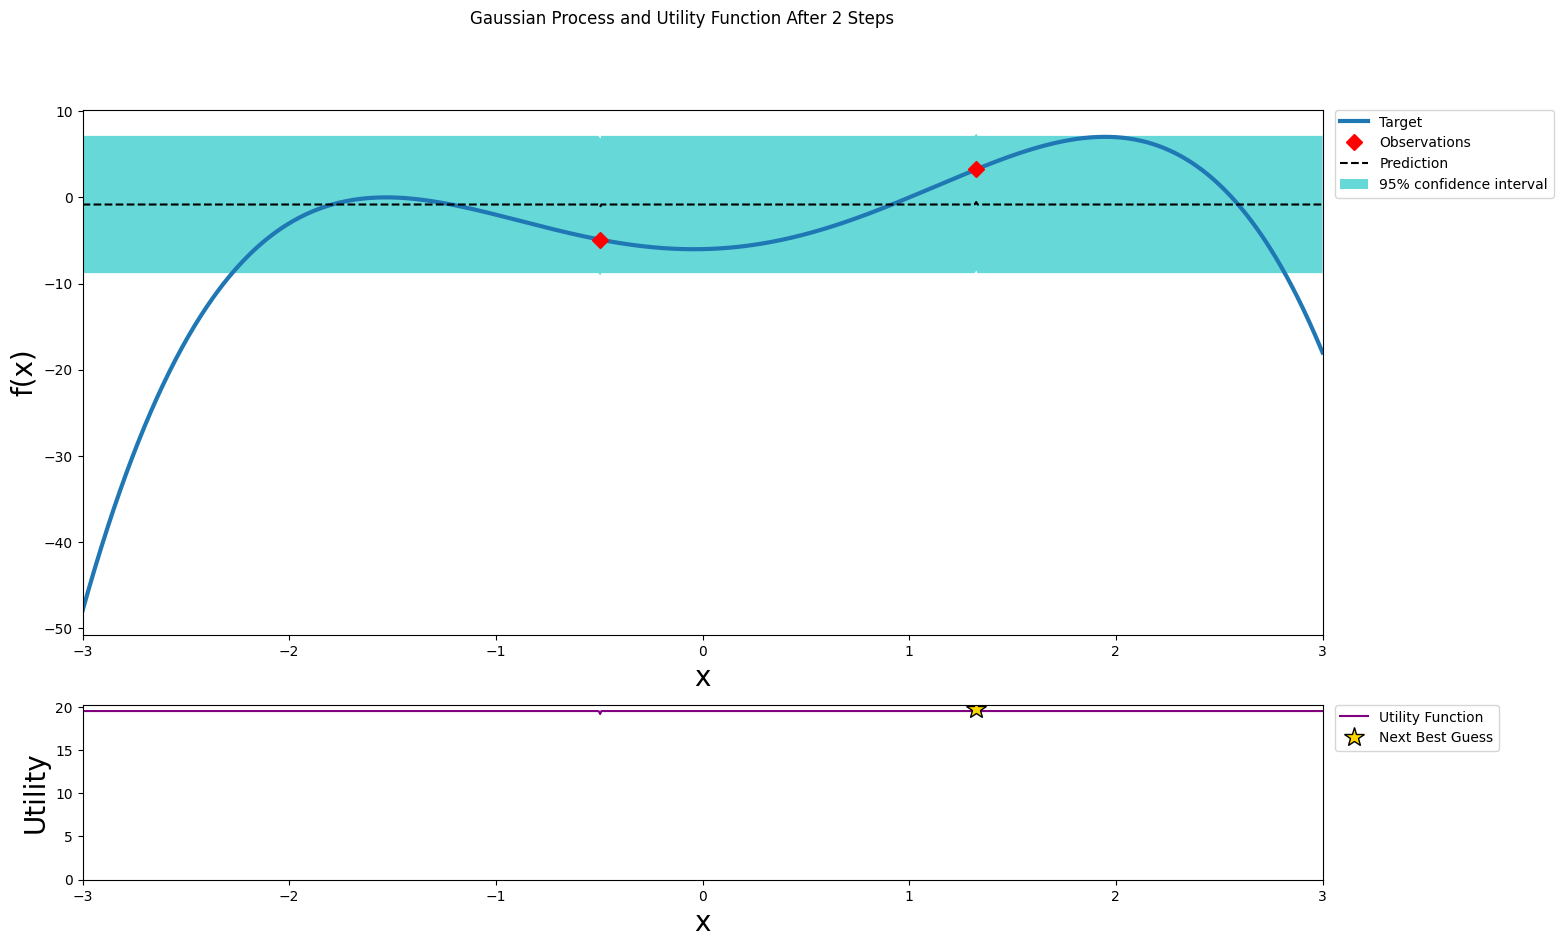

In [25]:
optimizer = start_optimizer(domain)
plot_gp(optimizer, domain)

### Iterate

After we probe two points at random, we can fit a Gaussian Process and start the bayesian optimization procedure. Two points should give us a uneventful posterior with the uncertainty growing as we go further from the observations.

After its iteration a new suggested point will be added to the observations, corresponding to the maximum obtained by the acquisition function. The acquisition function in this case is based on exploration-exploitation balance with high exploration focus.

|   iter    |  target   |     x     |
-------------------------------------
| 3         | 3.293     | 1.327     |
| 4         | 6.814     | 1.816     |
| 5         | -14.79    | 2.942     |
| 6         | -48.0     | -3.0      |
| 7         | -4.49     | 0.461     |
| 8         | 7.038     | 1.951     |
| 9         | 7.032     | 1.927     |
| 10        | -0.4989   | -1.291    |
| 11        | 6.055     | 2.198     |
| 12        | 6.271     | 1.696     |
| 13        | 6.44      | 1.727     |
| 14        | 6.697     | 2.099     |
| 15        | 6.594     | 1.76      |
| 16        | 6.855     | 2.06      |


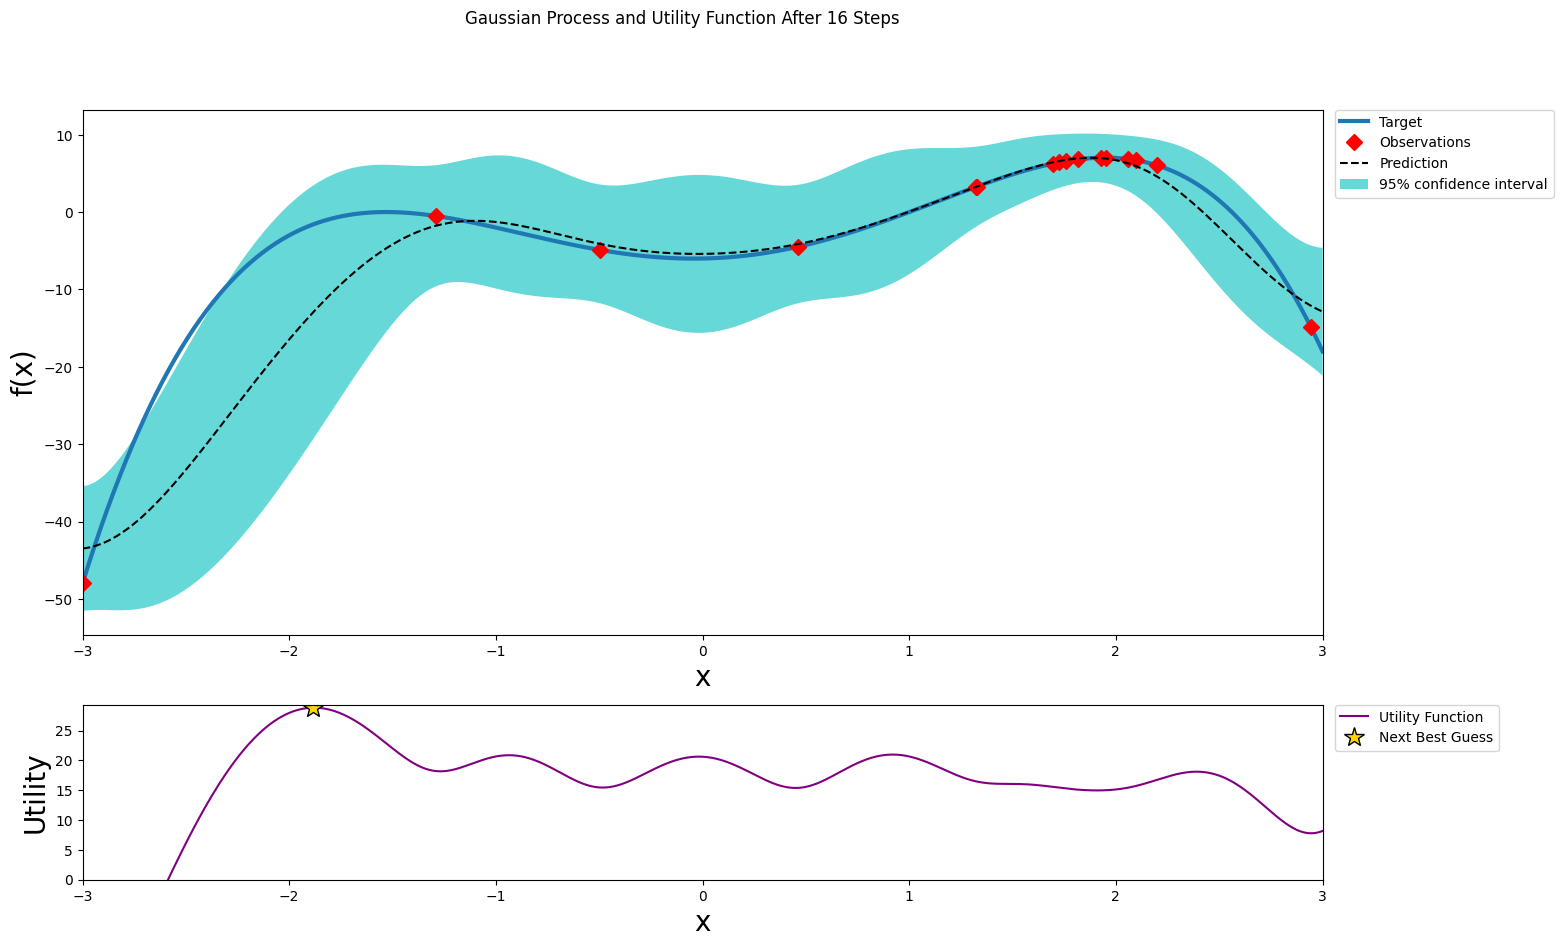

In [26]:
optimizer.maximize(init_points=0, n_iter=14)
plot_gp(optimizer, domain)

In [26]:
# Run full iterations
# optimizer.maximize(init_points=0, n_iter=20)
# plot_gp(optimizer, domain)